            Mean Temp (°C)
Date/Time                 
2019-01-01            -0.1
2019-01-02            -3.8
2019-01-03             0.5
2019-01-04             4.5
2019-01-05             2.5
...                    ...
2021-12-27            -2.0
2021-12-28             1.5
2021-12-29             2.0
2021-12-30             2.6
2021-12-31             4.9

[1086 rows x 1 columns]


<AxesSubplot:xlabel='Date/Time', ylabel='Mean Temp (°C)'>

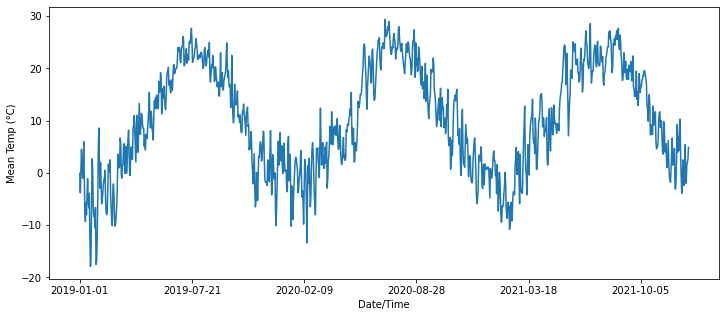

In [8]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import math
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
dataset = pd.read_csv('./data/weather_data_toronto.csv', index_col="Date/Time")

dataset.drop(["Longitude (x)","Latitude (y)","Station Name","Climate ID","Year","Month","Day","Data Quality","Max Temp Flag","Min Temp Flag","Mean Temp Flag","Heat Deg Days (°C)","Heat Deg Days Flag","Cool Deg Days (°C)","Cool Deg Days Flag","Total Rain (mm)","Total Rain Flag","Total Snow (cm)","Total Snow Flag","Total Precip (mm)","Total Precip Flag","Snow on Grnd (cm)","Snow on Grnd Flag","Dir of Max Gust (10s deg)","Dir of Max Gust Flag","Spd of Max Gust (km/h)","Spd of Max Gust Flag", "Min Temp (°C)", "Max Temp (°C)"], axis=1,inplace=True)
dataset=dataset.dropna()
print(dataset)

dataset['Mean Temp (°C)'].plot(figsize=(12,5), ylabel='Mean Temp (°C)')

In [2]:
split_point = int(724)
train, validation = dataset[0:split_point], dataset[split_point:]
print('Training Data %d, Validation %d' % (len(train), len(validation)))

Training Data 724, Validation 362


In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

X = train.values
days_in_year = 365
differenced = difference(X, days_in_year)
model = ARIMA(differenced, order=(1,1,2))
model_fit = model.fit()
# print summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  359
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1006.994
Date:                Thu, 31 Mar 2022   AIC                           2021.989
Time:                        17:29:02   BIC                           2037.511
Sample:                             0   HQIC                          2028.162
                                - 359                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4487      0.066      6.772      0.000       0.319       0.579
ma.L1         -0.5692      0.069     -8.267      0.000      -0.704      -0.434
ma.L2         -0.4193      0.068     -6.177      0.0

2021-01-01
    Date/Time  Mean Temp (°C)
0  2021-01-01        1.344854
1  2021-01-02        5.358369
2  2021-01-03        2.057987
3  2021-01-04        0.782159
4  2021-01-05        4.582741
VALIDATION
            Mean Temp (°C)
Date/Time                 
2021-01-01             0.7
2021-01-02             0.7
2021-01-03             1.1
2021-01-04             0.8
2021-01-05             1.1
      Date/Time  Mean Temp (°C)
0    2021-01-01        1.344854
1    2021-01-02        5.358369
2    2021-01-03        2.057987
3    2021-01-04        0.782159
4    2021-01-05        4.582741
..          ...             ...
357  2021-12-24        4.764599
358  2021-12-25       -1.135401
359  2021-12-26       -1.935401
360  2021-12-27        2.164599
361  2021-12-28        2.764599

[362 rows x 2 columns]


<AxesSubplot:xlabel='Date/Time', ylabel='Mean Temp (°C)'>

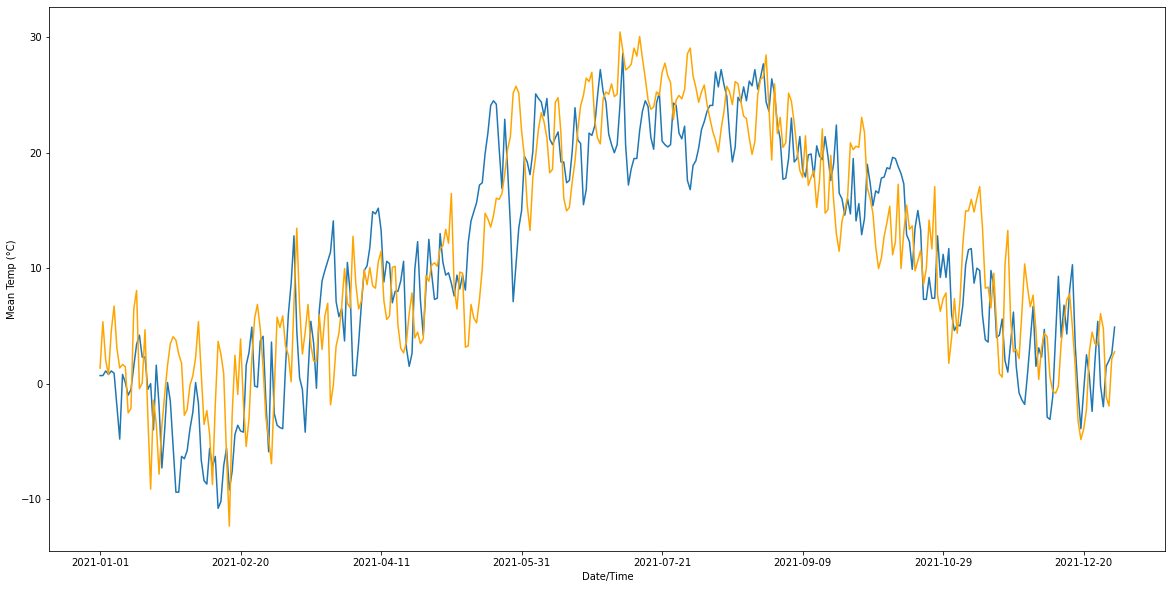

In [5]:
forecast = model_fit.forecast(steps=727)
history = [x for x in X]
starting_date = datetime.datetime.strptime("21-01-01", "%y-%m-%d").date()
print(starting_date)
day = 1
df = pd.DataFrame(columns=['Date/Time','Mean Temp (°C)'])

for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    #print('Day %d: %f' % (day, inverted))
    prediction = {'Date/Time':starting_date, 'Mean Temp (°C)':inverted[0]}
    df = df.append(prediction, ignore_index=True)
    history.append(inverted)
    day += 1
    starting_date=starting_date+datetime.timedelta(days=1)

print(df.head())
df.to_csv('predictions.csv', index=False)
print("VALIDATION")
print(validation.head())

validation['Mean Temp (°C)'].plot(figsize=(20,10))
model_prediction = df.iloc[0:362]
print(model_prediction)
model_prediction['Mean Temp (°C)'].plot(figsize=(20,10),color='orange',ylabel='Mean Temp (°C)')
#df['Mean Temp (°C)'].plot(figsize=(20,10),color='orange')

<AxesSubplot:xlabel='Date/Time', ylabel='Mean Temp (°C)'>

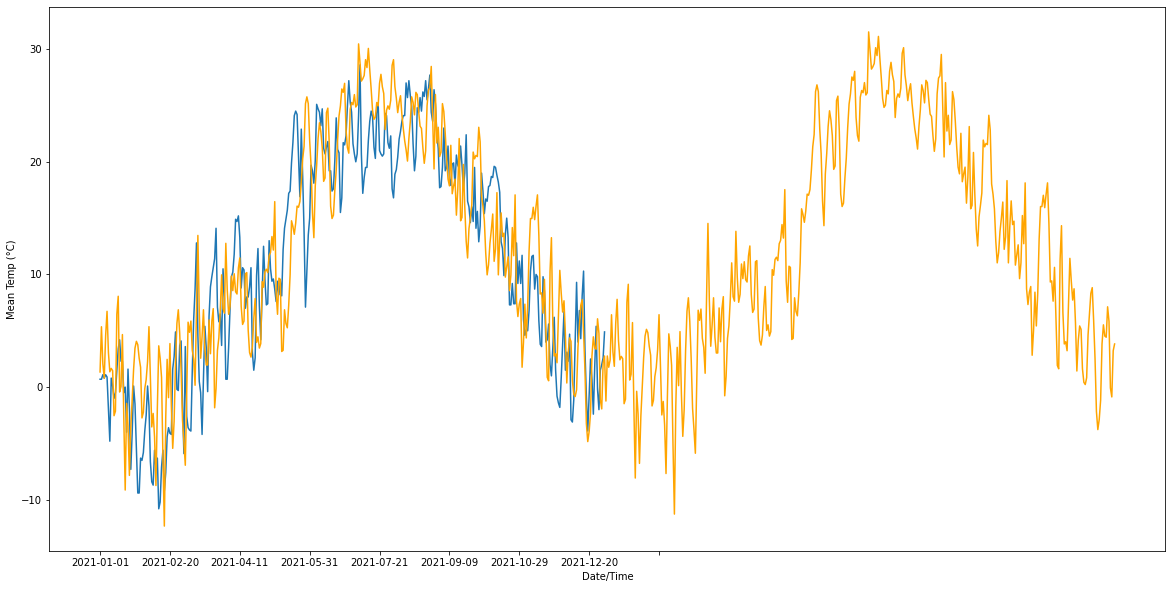

In [6]:
validation['Mean Temp (°C)'].plot(figsize=(20,10))
df['Mean Temp (°C)'].plot(figsize=(20,10),color='orange', ylabel='Mean Temp (°C)')

<AxesSubplot:xlabel='Date/Time', ylabel='Mean Temp (°C)'>

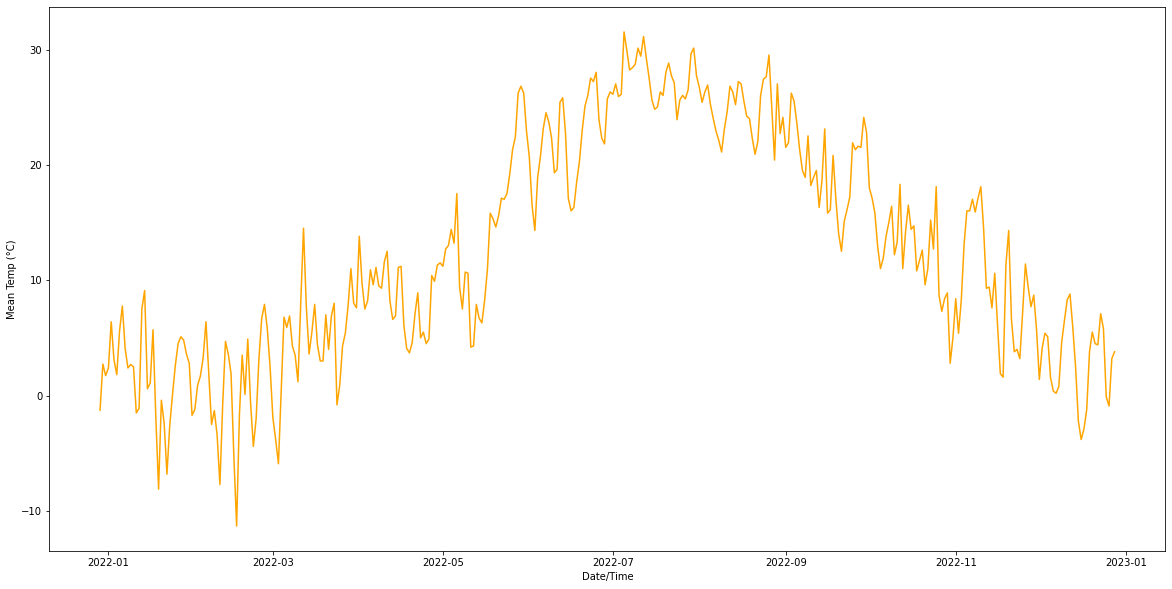

In [7]:
df=df.set_index('Date/Time')
future=df.iloc[362:]
future['Mean Temp (°C)'].plot(figsize=(20,10),color='orange', ylabel='Mean Temp (°C)')